In [1]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import subprocess
from matplotlib.animation import FuncAnimation
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
from scipy.io import loadmat
import natsort, pathlib
import os
import glob

In [2]:
colormap_data = loadmat('../cold2hot.mat')
cold2hot = ListedColormap(colormap_data['colormap'])
hot2cold = ListedColormap(colormap_data['colormap'][::-1])

In [3]:
path = os.path.abspath('../../0_MOOSE_Input_Files/Heat_Sources/')

# Ring HS

In [4]:
model_path_pf_PhaseVel = path+'/ML_Data/Ring/TDB/exodus/Au-Au.e'
model_path_temp_only = path+'/ML_Data/Ring/temp_only/exodus/Au-Au.e'

## Temperature only data

In [5]:
df1 = pd.read_csv(path+'/ML_Data/Ring/temp_only/exodus/Au-Au.csv',  encoding='utf-8')
real_time = np.array(df1['time'])
df1.head()

,time,temp_avg,temp_max,temp_min
0,0.00,0.000000,0.000000,0.000000
1,0.06,581.127028,2171.698467,300.028397
2,0.12,585.371712,2181.580875,300.031036
3,0.18,586.164783,2178.176205,300.031485
4,0.24,586.880866,2174.893405,300.031828


In [6]:
model = netCDF4.Dataset(model_path_temp_only)

In [7]:
parameters = ['vals_nod_var2']

In [8]:
temp = []
i = 0
param = model.variables[parameters[i]][:]
X_all = model.variables['coordx'][:]
Y_all = model.variables['coordy'][:]
points = np.vstack([Y_all,X_all,param]).T
column_names = ['X', 'Y'] + list(range(param.shape[0]))
df = pd.DataFrame(points, columns=column_names)
df = df.sort_values(by = ['X', 'Y'], ascending = [True, True], ignore_index=True)
df_param = df.iloc[:, 2:]

x_dim  = model.dimensions['num_nod_ns1'].size
y_dim =  model.dimensions['num_nod_ns2'].size
time_steps = model.dimensions['time_step'].size
array_ = df_param.to_numpy().flatten().reshape(y_dim, x_dim, time_steps)
array = np.flip(array_, axis=0)
temp.append(array)

In [9]:
t_ST = 16
time_steps = 401
dt = time_steps - t_ST
time = np.array(model.variables['time_whole'][:]).reshape((-1, ))[np.r_[t_ST:time_steps]]
temp = temp[0][:, :, np.r_[t_ST:time_steps]]
X_= np.moveaxis(temp, -1, 0)

X_, time = X_[0::8], time[0::8]

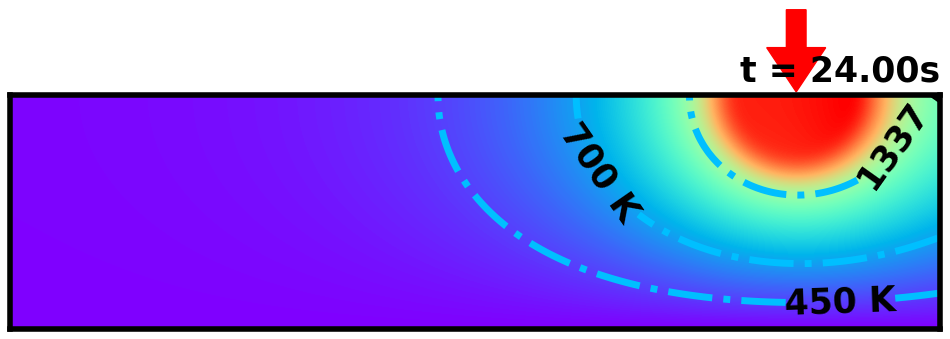

In [10]:
t_step = -1
laser_speed = 30
laser_pos = (125 + time[t_step]*laser_speed)* 401/1000  # Laser actual position in true dimension

fig, (ax1) = plt.subplots(1,1, figsize=(12,4), frameon=True)
cmap = plt.get_cmap('rainbow')
cmap.set_under('white', alpha=0)
hmap1 = ax1.imshow(X_[t_step], cmap=cmap, vmin=300,  aspect=0.5,  interpolation='quadric')
ax1.arrow(laser_pos,-75, 0, 71,  width = 8.5, color='red', length_includes_head=True, clip_on=False)
ax1.set_title(f't = {time[t_step]:.2f}s', pad=10, loc='right', fontsize=25, weight='bold')
for label in ax1.clabel(ax1.contour(X_[t_step], levels=[450, 700, 1337], colors='deepskyblue', linewidths=5, linestyles='dashdot'), inline=True, fontsize=25, colors='k', fmt='%1.0f K'): label.set_fontweight('bold')

ax1.set_ylim(201, -1); ax1.set_xlim(-1, 401); ax1.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False); ax1.spines[:].set_linewidth(4)


### Saving Individual frame as single numpy file

In [11]:
## Reshaping to torch model format
X_ = X_[:, np.newaxis, :, :]
X_.shape

(49, 1, 201, 401)

In [12]:
save_path = os.path.abspath('../../7_Virtual_Digital_Twin/T_data/individual_T_data/')

In [13]:
for i in range(len(time)):
    np.save(save_path+f'/Ring_X_{i}.npy', X_[i:i+1,:,:])

## Phase & Velocity data from PF simulation

In [5]:
df2 = pd.read_csv(path+'/ML_Data/Ring/TDB/exodus/Au-Au.csv',  encoding='utf-8')
real_time = np.array(df2['time'])
df2.head()

,time,area_h1,temp_avg,temp_max,temp_min
0,0.00,2680.208333,0.000000,0.000000,0.000000
1,0.06,2837.614059,566.238679,1886.099307,300.030249
2,0.12,3084.136185,568.963675,1892.472841,300.031222
3,0.18,3306.816108,569.655601,1889.718467,300.031558
4,0.24,3565.791747,570.329372,1887.332106,300.031890


In [16]:
model = netCDF4.Dataset(model_path_pf_PhaseVel)

In [17]:
names = model.variables["name_nod_var"]
names.set_auto_mask(False)
param_in_exodus = [b"".join(c).decode("latin1") for c in names[:]]
print(param_in_exodus)

['eta1', 'p', 'temp', 'vel_x', 'vel_y']


In [18]:
parameters = ['vals_nod_var1', 'vals_nod_var4', 'vals_nod_var5',]

In [19]:
def Exodus_Extractor(model) -> netCDF4._netCDF4.Dataset :
    LIQ, velX, velY = [], [], []
    for i in range(3):
        param = model.variables[parameters[i]][:]
        X_all = model.variables['coordx'][:]
        Y_all = model.variables['coordy'][:]
        points = np.vstack([Y_all,X_all,param]).T
        column_names = ['X', 'Y'] + list(range(param.shape[0]))
        df = pd.DataFrame(points, columns=column_names)
        df = df.sort_values(by = ['X', 'Y'], ascending = [True, True], ignore_index=True)
        df_param = df.iloc[:, 2:]
        x_dim  = model.dimensions['num_nod_ns1'].size
        y_dim =  model.dimensions['num_nod_ns2'].size
        time_steps = model.dimensions['time_step'].size
        array_ = df_param.to_numpy().flatten().reshape(y_dim, x_dim, time_steps)
        array = np.flip(array_, axis=0)
        if i == 0:
            LIQ.append(array)
        elif i == 1:
            velX.append(array)
        else:
            velY.append(array)

    vel = (velX[0]**2 + velY[0]**2)**0.5
    velX, velY = [], []
    return LIQ[0], vel

In [31]:
LIQ, vel = Exodus_Extractor(model)

In [32]:
## BHS 66;477 | GHS 52;455 | FTHS 62;469 | RHS 17;419 
t_ST = 2*8
time_steps = 1+2*200
dt = time_steps - t_ST
time = np.array(model.variables['time_whole'][:]).reshape((-1, ))[np.r_[t_ST:time_steps]]
LIQ = np.where(LIQ < 0.5, 0, 1)
vel = np.round(np.where(LIQ < 0.5, 0, vel), decimals=2)

LIQ = LIQ[:, :, np.r_[t_ST:time_steps]]
vel = vel[:, :, np.r_[t_ST:time_steps]]

y_ = np.moveaxis(LIQ, -1, 0)
vel_ = np.moveaxis(vel, -1, 0)

y_, vel_, time = y_[0::8], vel_[0::8], time[0::8]

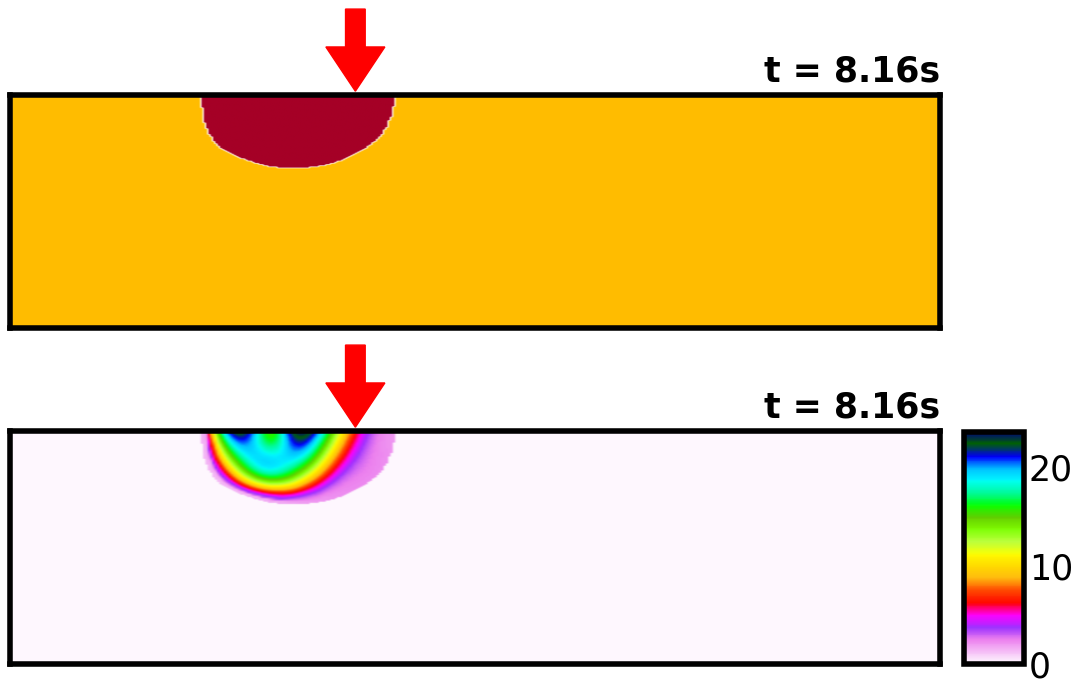

In [60]:
t_step = 15
laser_speed = 30
laser_pos = (125 + time[t_step]*laser_speed)* 401/1000  # Laser actual position in true dimension

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8), frameon=True)
cmap = plt.get_cmap('RdYlGn_r')
cmap.set_under('white', alpha=0)
hmap3 = ax1.imshow(y_[t_step], cmap=cmap, vmin=0.5, vmax=1.0, aspect=0.5,  interpolation='quadric')
cmap = plt.get_cmap('Wistia')
cmap.set_under('white', alpha=0) 
hmap4 = ax1.imshow(1-y_[t_step], cmap=cmap, vmin=0.5, vmax=1.5, aspect=0.5, interpolation='quadric')
ax1.arrow(laser_pos,-75, 0, 71,  width = 8.5, color='red', length_includes_head=True, clip_on=False)
ax1.set_title(f't = {time[t_step]:.2f}s', pad=10, loc='right', fontsize=25, weight='bold')
ax1.set_ylim(201, -1); ax1.set_xlim(-1, 401); ax1.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False); ax1.spines[:].set_linewidth(4)


cmap = plt.get_cmap('gist_ncar_r')
hmap1 = ax2.imshow(vel_[t_step], cmap=cmap, vmin=0.0, aspect=0.5,  interpolation='quadric')
# cbar = fig.colorbar(trues_map, label=r'vel $\mu m/s$', orientation='vertical')

ax2.arrow(laser_pos,-75, 0, 71,  width = 8.5, color='red', length_includes_head=True, clip_on=False)
ax2.set_title(f't = {time[t_step]:.2f}s', pad=10, loc='right', fontsize=25, weight='bold')
ax2.set_ylim(201, -1); ax2.set_xlim(-1, 401); ax2.tick_params(axis='both', labelcolor='black', labelsize=65, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False); ax2.spines[:].set_linewidth(4)

# ############## Color Bar ###########
ax3 = fig.add_axes([0.92, 0.14, 0.05, 0.29]) 
ax3.tick_params(axis='both', labelcolor='black', labelsize=1, bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
cbar = fig.colorbar(hmap1, cax=ax3, orientation='vertical')
cbar.ax.tick_params(labelsize=25, direction='in', length=0) 
ax3.spines[:].set_linewidth(4)

plt.show()

In [61]:
## Reshaping to torch model format
y_ = y_[:, np.newaxis, :, :]
vel_ = vel_[:, np.newaxis, :, :]
y_.shape, vel_.shape

((49, 1, 201, 401), (49, 1, 201, 401))

In [32]:
## Save phase data
save_path = os.path.abspath('../../8_Virtual_Digital_Twin/T_data/individual_y_data/')
for i in range(len(time)):
    np.save(save_path+f'/Ring_y_{i}.npy', y_[i:i+1,:,:])

In [62]:
## Save velocity data
save_path = os.path.abspath('../../8_Virtual_Digital_Twin/T_data/individual_vel_data/')
for i in range(len(time)):
    np.save(save_path+f'/Ring_vel_{i}.npy', vel_[i:i+1,:,:])